In [38]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle

In [ ]:
# 确定设备，如果GPU可用则使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Deep learning method

In [ ]:
# 深度学习方法参数
AGENTS = 50  # 代理人数量
LEARNING_RATE = 1e-3
TRAINING_STEPS = 30000
BATCH_SIZE = 10 # 平行经济个数
DISPLAY_STEP = 1000
TRAIN_STEP_INTERVAL = 2  # 训练周期之间的步骤间隔

## Krusell and Smith's (1998) model

## Preliminaries

In [41]:
# 模型参数
α = 0.36  # 柯布-道格拉斯生产函数中的资本份额
d = 0.08  # 折旧率
A = 1  # 技术水平
β = 0.96  # 时间偏好/贴现因子
γ = 1  # 风险规避参数。CRRA效用函数。

mean_z = 0.0  # 总生产率冲击
ρ_z = 0.9  # 总生产率冲击的持续性
σ_z = 0.01  # 标准差

mean_y = 0.0  # 异质性生产率冲击
ρ_y = 0.95  # 异质性生产率冲击的持续性
σ_y = 0.2  # 标准差

In [42]:
# 稳态
K_STEADY_STATE = (((1 / β) - (1 - d)) / (α * A)) ** (1 / (α - 1))  # 资本
W_STEADY_STATE = K_STEADY_STATE * (1 - d) + A * K_STEADY_STATE ** α  # 财富
C_STEADY_STATE = A * K_STEADY_STATE ** α - d * K_STEADY_STATE  # 消费
ξ_STEADY_STATE = C_STEADY_STATE / W_STEADY_STATE  # 消费财富比, ksi

## Stochastic solution domain

In [43]:
# 状态变量的边界
z_min = math.exp(-2 * σ_z / math.sqrt(1 - ρ_z ** 2))
z_max = math.exp(2 * σ_z / math.sqrt(1 - ρ_z ** 2))
y_min = math.exp(-2 * σ_y / math.sqrt(1 - ρ_y ** 2))
y_max = math.exp(2 * σ_y / math.sqrt(1 - ρ_y ** 2))
w_min = 0.0 * W_STEADY_STATE
w_max = 4.0 * W_STEADY_STATE

In [ ]:
# Model functions
def mean_across_agents(x):
    return torch.mean(x, dim=1, keepdim=True)

def consumption_capital(w, ξ):
    c = w * ξ
    kp = w * (1 - ξ)  # k' = 下一期的个人资本
    kp = torch.clamp(kp, max=w_max)  # 如果 kp > W_HIGH，则设置 kp = W_HIGH
    c = w - kp  # 重新计算 c
    return c, kp

def next_period(kp, yp, zp):
    kp_aggregate = mean_across_agents(kp)
    rp = A * zp * α * kp_aggregate ** (α - 1)  # 下一期的利率
    wagep = A * zp * (1 - α) * kp_aggregate ** (α)  # 下一期的工资
    wp = (1 - d + rp) * kp + wagep * yp  # 个人下一期的财富
    return rp, wp

def productivity_transition_to_next_period(y, z, εy, εz):
    yp = y ** ρ_y * torch.exp(εy) * math.exp((-0.5 * (1 - ρ_y) * σ_y ** 2) / (1 - ρ_y ** 2))
    yp = torch.clamp(yp, min=y_min, max=y_max)
    # normalize future individual shocks so that they sum up to one
    yp = yp / mean_across_agents(yp)
    zp = z ** ρ_z * torch.exp(εz) * math.exp((-0.5 * (1 - ρ_z) * σ_z ** 2) / (1 - ρ_z ** 2))
    zp = torch.clamp(zp, min=z_min, max=z_max)
    return yp, zp

def normalize_all(w, y, z):  # 为神经网络规范化输入
    normw = (w - w_min) / (w_max - w_min) * 2.0 - 1.0  # 规范化到[-1,1]区间
    normy = torch.log(y) / (2 * σ_y / math.sqrt(1 - ρ_y ** 2))  # 约等于[-1,1]
    normz = torch.log(z) / (2 * σ_z / math.sqrt(1 - ρ_z ** 2))
    return normw, normy, normz

## The neural-network

In [45]:
class KrusellSmithNet(nn.Module):
    def __init__(self, input_dimension, output_dimension):
        super(KrusellSmithNet, self).__init__()
        self.fc1 = nn.Linear(input_dimension, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_dimension)
        self.sigmoid = nn.Sigmoid()
        # 应用初始化
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # 使用Xavier均匀分布初始化权重
            nn.init.xavier_uniform_(module.weight)
            # 将偏置项初始化为0
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

input_dimension = 2 * AGENTS + 3
output_dimension = 2
model = KrusellSmithNet(input_dimension, output_dimension).to(device)


In [46]:
# NN functions that produce decision variables
def run_neural_network_for_all_agents_given_state(w, y, z):
    normw, normy, normz = normalize_all(w, y, z)
    normw_unstacked = torch.unbind(normw, dim=1)
    normy_unstacked = torch.unbind(normy, dim=1)
    
    sum_information = [torch.unsqueeze(x, dim=0) for x in normw_unstacked + normy_unstacked]
    
    concat_list = []
    for i in range(AGENTS):
        concat_list.append(torch.cat(
            sum_information +
            [normz.T,
             torch.unsqueeze(normw_unstacked[i], 0),
             torch.unsqueeze(normy_unstacked[i], 0)],
            dim=0
        ))
        
    stack = torch.stack(concat_list, dim=1)
    input_tensor = stack.permute(2, 1, 0).reshape(-1, input_dimension)

    output_tensor = model(input_tensor)
    output_tensor_reshaped = output_tensor.reshape(-1, AGENTS, output_dimension)
    
    ξ_before_sigmoid, μ_before_exp = torch.unbind(output_tensor_reshaped, dim=2)
    
    def logit(x):
        return np.log(x / (1 - x))

    ξ = torch.sigmoid(ξ_before_sigmoid + logit(ξ_STEADY_STATE))
    μ = torch.exp(μ_before_exp)
    return ξ, μ


## Define the model through a computational graph

In [47]:
def run_model(w0, y0, z0, εy_a, εz_a, εy_b, εz_b):
    ξ0, μ0 = run_neural_network_for_all_agents_given_state(w0, y0, z0)
    c0, k1 = consumption_capital(w0, ξ0)
    y1_a, z1_a = productivity_transition_to_next_period(y0, z0, εy_a, εz_a)
    r1_a, w1_a = next_period(k1, y1_a, z1_a)
    ξ1_a, μ1_a = run_neural_network_for_all_agents_given_state(w1_a, y1_a, z1_a)
    c1_a, k2_a = consumption_capital(w1_a, ξ1_a)
    y1_b, z1_b = productivity_transition_to_next_period(y0, z0, εy_b, εz_b)
    r1_b, w1_b = next_period(k1, y1_b, z1_b)
    ξ1_b, μ1_b = run_neural_network_for_all_agents_given_state(w1_b, y1_b, z1_b)
    c1_b, k2_b = consumption_capital(w1_b, ξ1_b)

    R_μ = μ0 - 1
    R_ξ = w0 / c0 - 1
    R_μξ = R_μ + R_ξ - torch.sqrt(R_μ ** 2 + R_ξ ** 2)
    R2_a = β * (c1_a ** (-γ)) * (1 - d + r1_a) / (c0 ** (-γ)) - μ0
    R2_b = β * (c1_b ** (-γ)) * (1 - d + r1_b) / (c0 ** (-γ)) - μ0
    
    Residual1 = torch.mean(R_μξ ** 2)
    Residual2 = torch.mean(R2_a * R2_b)
    loss_op = Residual1 + Residual2
    
    return ξ0, μ0, c0, k1, y1_a, z1_a, r1_a, w1_a, ξ1_a, μ1_a, c1_a, k2_a, \
           y1_b, z1_b, r1_b, w1_b, ξ1_b, μ1_b, c1_b, k2_b, loss_op, Residual1, Residual2


## Training

In [48]:
loss_vals = np.empty((TRAINING_STEPS, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [49]:
def initial_state(required_batch_size):
    w = np.reshape(np.random.uniform(W_STEADY_STATE, W_STEADY_STATE, required_batch_size * AGENTS),
                   (required_batch_size, AGENTS))
    y = np.reshape(np.random.uniform(1, 1, required_batch_size * AGENTS), (required_batch_size, AGENTS))
    z = np.reshape(np.random.uniform(1, 1, required_batch_size), (required_batch_size, 1))
    w = torch.tensor(w, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).to(device)
    z = torch.tensor(z, dtype=torch.float32).to(device)
    return w, y, z

def generate_εy(required_batch_size):
    return torch.tensor(np.reshape(np.random.normal(mean_y, σ_y, required_batch_size * AGENTS),
                                 (required_batch_size, AGENTS)), dtype=torch.float32).to(device)

def generate_εz(required_batch_size):
    return torch.tensor(np.reshape(np.random.normal(mean_z, σ_z, required_batch_size),
                                 (required_batch_size, 1)), dtype=torch.float32).to(device)

In [50]:
start = time.time()

w_train, y_train, z_train = initial_state(required_batch_size=BATCH_SIZE)

for i in range(TRAINING_STEPS):
    εy_a_train = generate_εy(BATCH_SIZE)
    εy_b_train = generate_εy(BATCH_SIZE)
    εz_a_train = generate_εz(BATCH_SIZE)
    εz_b_train = generate_εz(BATCH_SIZE)

    if i % TRAIN_STEP_INTERVAL == 0:
        optimizer.zero_grad()
        _, _, _, _, y1_a, z1_a, _, w1_a, _, _, _, _, _, _, _, _, _, _, _, _, loss_op, Residual1, Residual2 = \
            run_model(w0=w_train, y0=y_train, z0=z_train, εy_a=εy_a_train, εy_b=εy_b_train,
                      εz_a=εz_a_train, εz_b=εz_b_train)
        loss_op.backward()
        optimizer.step()
    else:
        with torch.no_grad():
            _, _, _, _, y1_a, z1_a, _, w1_a, _, _, _, _, _, _, _, _, _, _, _, _, loss_op, Residual1, Residual2 = \
                run_model(w0=w_train, y0=y_train, z0=z_train, εy_a=εy_a_train, εy_b=εy_b_train,
                          εz_a=εz_a_train, εz_b=εz_b_train)

    loss_vals[i] = loss_op.item()
    w_train = w1_a.detach()
    y_train = y1_a.detach()
    z_train = z1_a.detach()

    if i % DISPLAY_STEP == 0:
        print(f"Loss at {i}: {loss_op.item()} (Residual1={Residual1.item()}, Residual2={Residual2.item()})")

time_elapsed = time.time() - start
print(f"Training took {time_elapsed} seconds.")


Loss at 0: 0.3878301680088043 (Residual1=0.22386480867862701, Residual2=0.1639653593301773)
Loss at 1000: 0.001145586371421814 (Residual1=7.577494397992268e-05, Residual2=0.0010698114056140184)
Loss at 2000: 0.0006543273339048028 (Residual1=0.00010660856787580997, Residual2=0.0005477187805809081)
Loss at 3000: 0.000746429490391165 (Residual1=0.0001314843975706026, Residual2=0.0006149450782686472)
Loss at 4000: 0.0004732701927423477 (Residual1=0.00015024900494609028, Residual2=0.0003230211732443422)
Loss at 5000: 0.00031312095234170556 (Residual1=0.00011165034084115177, Residual2=0.00020147062605246902)
Loss at 6000: 0.00046540063340216875 (Residual1=8.229122613556683e-05, Residual2=0.0003831094072666019)
Loss at 7000: 0.00012583515490405262 (Residual1=5.630847590509802e-05, Residual2=6.952668627491221e-05)
Loss at 8000: -1.0654890502337366e-05 (Residual1=5.592924571828917e-05, Residual2=-6.658413622062653e-05)
Loss at 9000: 0.0008735308074392378 (Residual1=2.9628887205035426e-05, Resid

## Decision-rule plot run

In [51]:
# --- Part 1: 计算决策规则以供绘图 ---
print("\nPart 1: Calculating decision rules for plotting...")
DECISION_RULE_PLOT_POINTS = 100
DECISION_RULE_Y_REALIZATIONS = 7

# 从训练结束时的状态中，取出第一个batch作为绘图基准
w_plot_base = w_train[0].cpu().numpy()
y_plot_base = y_train[0].cpu().numpy()
z_plot_base = z_train[0].cpu().numpy()

# 准备绘图网格 (w, y, z)
w_grid = np.repeat(np.expand_dims(w_plot_base, 0), DECISION_RULE_PLOT_POINTS, axis=0)
w_linspace = np.linspace(w_min, w_max, DECISION_RULE_PLOT_POINTS)
w_grid[:, 0] = w_linspace # 改变第一个agent的财富
w_grid = np.repeat(np.expand_dims(w_grid, 1), DECISION_RULE_Y_REALIZATIONS, axis=1)

y_grid = np.repeat(np.expand_dims(y_plot_base, 0), DECISION_RULE_Y_REALIZATIONS, axis=0)
y_linspace = np.linspace(y_min, y_max, DECISION_RULE_Y_REALIZATIONS)
y_grid[:, 0] = y_linspace # 改变第一个agent的生产率
y_grid = np.repeat(np.expand_dims(y_grid, 0), DECISION_RULE_PLOT_POINTS, axis=0)

z_grid = np.full((DECISION_RULE_PLOT_POINTS, DECISION_RULE_Y_REALIZATIONS, 1), z_plot_base[0])

decision_rule_results = {
    "w0": np.empty_like(w_grid),
    "c0": np.empty_like(w_grid),
}

with torch.no_grad():
    for step in range(DECISION_RULE_PLOT_POINTS):
        w_tensor = torch.tensor(w_grid[step], dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_grid[step], dtype=torch.float32).to(device)
        z_tensor = torch.tensor(z_grid[step], dtype=torch.float32).to(device)
        ξ0, _ = run_neural_network_for_all_agents_given_state(w_tensor, y_tensor, z_tensor)
        c0, _ = consumption_capital(w_tensor, ξ0)
        decision_rule_results["w0"][step] = w_grid[step]
        decision_rule_results["c0"][step] = c0.cpu().numpy()


Part 1: Calculating decision rules for plotting...


## Simulation plot run

In [52]:
# --- Part 2: 运行长期模拟 ---
print("\nPart 2: Running long-term simulation...")
SIMULATION_TIME_PERIODS = 1000

# 初始化存储结果的字典
simulation_results = {
    "k": np.empty(shape=(SIMULATION_TIME_PERIODS, 1, AGENTS)),
    "c": np.empty(shape=(SIMULATION_TIME_PERIODS, 1, AGENTS)),
}

# 从训练结束时的状态中，取出第一个样本作为模拟初始点
w_sim = w_train.detach()[:1]
y_sim = y_train.detach()[:1]
z_sim = z_train.detach()[:1]

# 重新定义一个简化的run_model，只返回需要的值，避免不必要的计算
def run_simulation_step(w0, y0, z0):
    εy = generate_εy(1)
    εz = generate_εz(1)
    ξ0, _ = run_neural_network_for_all_agents_given_state(w0, y0, z0)
    c0, k1 = consumption_capital(w0, ξ0)
    y1, z1 = productivity_transition_to_next_period(y0, z0, εy, εz)
    _, w1 = next_period(k1, y1, z1)
    return c0, k1, w1, y1, z1

with torch.no_grad():
    for step in range(SIMULATION_TIME_PERIODS):
        c0, k1, w1, y1, z1 = run_simulation_step(w_sim, y_sim, z_sim)
        
        simulation_results["c"][step] = c0.cpu().numpy()
        simulation_results["k"][step] = k1.cpu().numpy()
        
        w_sim, y_sim, z_sim = w1, y1, z1


Part 2: Running long-term simulation...


## Plotting


Part 3: Generating final plots...


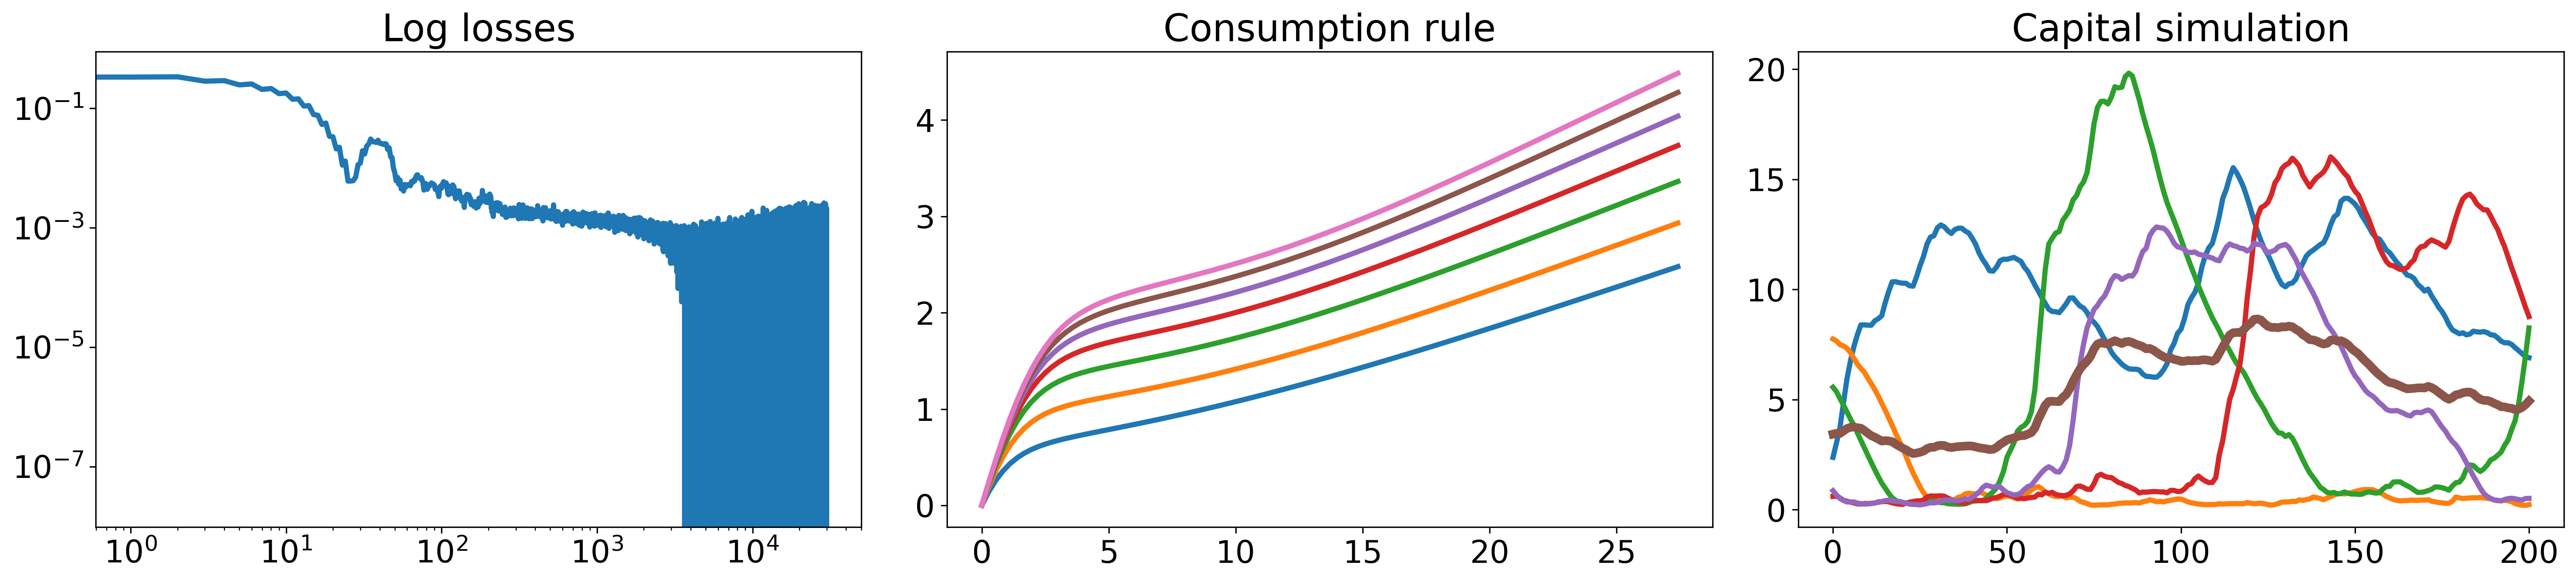

In [ ]:
# --- Part 3: 绘图 ---
print("\nPart 3: Generating final plots...")
plt.rcParams.update({'agg.path.chunksize': 100000, 'lines.linewidth': 3, 
                     'figure.dpi': 300, 'font.size': 18})

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# 图 1: Log losses
axes[0].plot(loss_vals)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_title("Log losses")

# 图 2: Consumption rule
for i in range(DECISION_RULE_Y_REALIZATIONS):
    # 绘制agent 0的消费规则，对应不同的y值
    axes[1].plot(decision_rule_results["w0"][:, i, 0], decision_rule_results["c0"][:, i, 0])
axes[1].set_title("Consumption rule")

# 图 3: Capital simulation (截取长期模拟结果)
start = 200
end = 400
for i in range(min(5, AGENTS)): # 只绘制前5个agent
    axes[2].plot(simulation_results["k"][start:end+1, 0, i])
# 绘制这5个agent的平均资本路径
axes[2].plot(np.mean(simulation_results["k"][start:end+1, 0, :min(5, AGENTS)], axis=1), 
             linewidth=5.0)
axes[2].set_title("Capital simulation")

plt.tight_layout()
plt.show()